# Linear Regression for Car Price Prediction

A beginner-friendly approach to predict used car prices using linear regression.

## What we'll do:
1. Load the data
2. Clean the data
3. Prepare features
4. Train the model
5. Make predictions
6. Check how good our model is


In [1]:
# Step 1: Import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Step 2: Load the data
data = pd.read_csv('used_cars_dataset.csv')

print("Dataset loaded!")
print(f"Number of cars: {len(data)}")
print(f"Number of features: {len(data.columns)}")

# Look at first 5 rows
print("\nFirst 5 cars:")
print(data.head())

Dataset loaded!
Number of cars: 4340
Number of features: 8

First 5 cars:
                       name  year  km_driven    fuel seller_type transmission  \
0             Maruti 800 AC  2007      70000  Petrol  Individual       Manual   
1  Maruti Wagon R LXI Minor  2007      50000  Petrol  Individual       Manual   
2      Hyundai Verna 1.6 SX  2012     100000  Diesel  Individual       Manual   
3    Datsun RediGO T Option  2017      46000  Petrol  Individual       Manual   
4     Honda Amaze VX i-DTEC  2014     141000  Diesel  Individual       Manual   

          owner  selling_price  
0   First Owner          60000  
1   First Owner         135000  
2   First Owner         600000  
3   First Owner         250000  
4  Second Owner         450000  


In [3]:
# Step 3: Understand our data
print("Basic information about our data:")
print(data.info())

print("\nPrice statistics:")
print(f"Cheapest car: ₹{data['selling_price'].min():,}")
print(f"Most expensive car: ₹{data['selling_price'].max():,}")
print(f"Average price: ₹{data['selling_price'].mean():,.0f}")

Basic information about our data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   km_driven      4340 non-null   int64 
 3   fuel           4340 non-null   object
 4   seller_type    4340 non-null   object
 5   transmission   4340 non-null   object
 6   owner          4340 non-null   object
 7   selling_price  4340 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 271.4+ KB
None

Price statistics:
Cheapest car: ₹20,000
Most expensive car: ₹8,900,000
Average price: ₹504,127


In [4]:
# Step 4: Clean the data (remove bad entries) - IMPROVED
print("Cleaning the data...")

# Remove duplicates
data_clean = data.drop_duplicates()
print(f"Removed {len(data) - len(data_clean)} duplicate cars")

# Remove cars with unrealistic prices (better range)
data_clean = data_clean[(data_clean['selling_price'] >= 25000) & (data_clean['selling_price'] <= 8000000)]
print(f"Removed cars with unrealistic prices")

# Remove very old cars (before 2005 for better accuracy)
data_clean = data_clean[data_clean['year'] >= 2005]
print(f"Removed very old cars")

# Remove cars with too high mileage (unrealistic)
data_clean = data_clean[data_clean['km_driven'] <= 500000]
print(f"Removed cars with unrealistic mileage")

# Remove outliers using simple method
Q1 = data_clean['selling_price'].quantile(0.25)
Q3 = data_clean['selling_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

before_outliers = len(data_clean)
data_clean = data_clean[(data_clean['selling_price'] >= lower_bound) & 
                       (data_clean['selling_price'] <= upper_bound)]
print(f"Removed {before_outliers - len(data_clean)} price outliers")

print(f"\nFinal dataset: {len(data_clean)} cars")

Cleaning the data...
Removed 763 duplicate cars
Removed cars with unrealistic prices
Removed very old cars
Removed cars with unrealistic mileage
Removed 187 price outliers

Final dataset: 3254 cars


In [5]:
# Step 5: Prepare our features (the things that affect car price) - IMPROVED
print("Preparing features...")

# Create age of car
data_clean['age'] = 2024 - data_clean['year']

# Create brand from car name (first word)
data_clean['brand'] = data_clean['name'].str.split().str[0]

# Create usage per year (how much the car was driven per year)
data_clean['km_per_year'] = data_clean['km_driven'] / (data_clean['age'] + 1)

# Create luxury brand indicator (simple but effective)
luxury_brands = ['BMW', 'Mercedes-Benz', 'Audi', 'Jaguar', 'Land', 'Volvo']
data_clean['is_luxury'] = data_clean['brand'].isin(luxury_brands).astype(int)

# Create premium brand indicator
premium_brands = ['Toyota', 'Honda', 'Hyundai', 'Skoda', 'Volkswagen', 'Nissan']
data_clean['is_premium'] = data_clean['brand'].isin(premium_brands).astype(int)

# Convert text to numbers for the computer to understand
# Fuel type: Petrol=0, Diesel=1, CNG=2, etc.
fuel_map = {'Petrol': 0, 'Diesel': 1, 'CNG': 2, 'LPG': 3, 'Electric': 4}
data_clean['fuel_num'] = data_clean['fuel'].map(fuel_map).fillna(0)

# Transmission: Manual=0, Automatic=1
data_clean['transmission_num'] = (data_clean['transmission'] == 'Automatic').astype(int)

# Owner: First=0, Second=1, Third=2, etc.
owner_map = {'First Owner': 0, 'Second Owner': 1, 'Third Owner': 2, 'Fourth & Above Owner': 3}
data_clean['owner_num'] = data_clean['owner'].map(owner_map).fillna(0)

# Seller type: Individual=0, Dealer=1
data_clean['seller_num'] = (data_clean['seller_type'] == 'Dealer').astype(int)

print("Features prepared!")
print(f"Average car age: {data_clean['age'].mean():.1f} years")
print(f"Luxury cars: {data_clean['is_luxury'].sum()}")
print(f"Premium cars: {data_clean['is_premium'].sum()}")

Preparing features...
Features prepared!
Average car age: 10.8 years
Luxury cars: 16
Premium cars: 1122


In [6]:
# Step 6: Choose which features to use for prediction - IMPROVED
features = ['year', 'km_driven', 'age', 'km_per_year', 'is_luxury', 'is_premium', 
           'fuel_num', 'transmission_num', 'owner_num', 'seller_num']

# X = features (what we use to predict)
X = data_clean[features]

# y = target (what we want to predict)
y = data_clean['selling_price']

print(f"Using {len(features)} features to predict car price:")
for i, feature in enumerate(features):
    print(f"  {i+1}. {feature}")

print(f"\nWe have {len(X)} cars to learn from")

Using 10 features to predict car price:
  1. year
  2. km_driven
  3. age
  4. km_per_year
  5. is_luxury
  6. is_premium
  7. fuel_num
  8. transmission_num
  9. owner_num
  10. seller_num

We have 3254 cars to learn from


In [7]:
# Step 7: Split data into training and testing - IMPROVED
# Training data: teach the model
# Testing data: check how good the model is

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data: {len(X_train)} cars")
print(f"Testing data: {len(X_test)} cars")

# Scale the features (make them similar ranges for better performance)
print("\nScaling features for better performance...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preparation completed!")

Training data: 2603 cars
Testing data: 651 cars

Scaling features for better performance...
Data preparation completed!


In [8]:
# Step 8: Create and train the model - IMPROVED
print("Training the model...")

# Create the linear regression model
model = LinearRegression()

# Train the model using scaled training data (better performance)
model.fit(X_train_scaled, y_train)

print("Model training completed!")
print("\nThe model learned how features affect car prices.")

Training the model...
Model training completed!

The model learned how features affect car prices.


In [9]:
# Step 9: Make predictions - IMPROVED
print("Making predictions...")

# Predict prices for training data (using scaled features)
y_train_pred = model.predict(X_train_scaled)

# Predict prices for testing data (using scaled features)
y_test_pred = model.predict(X_test_scaled)

print("Predictions completed!")
print(f"Made predictions for {len(y_test_pred)} test cars")

Making predictions...
Predictions completed!
Made predictions for 651 test cars


In [10]:
# Step 10: Check how good our model is
print("Checking model performance...")

# R² Score: How well the model explains the data (0 to 1, higher is better)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Mean Absolute Error: Average difference between actual and predicted prices
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nModel Performance:")
print(f"Training R² Score: {train_r2:.3f} ({train_r2*100:.1f}% accuracy)")
print(f"Testing R² Score: {test_r2:.3f} ({test_r2*100:.1f}% accuracy)")
print(f"\nAverage Prediction Error:")
print(f"Training: ₹{train_mae:,.0f}")
print(f"Testing: ₹{test_mae:,.0f}")

# Simple interpretation
if test_r2 > 0.8:
    print("\n🎉 Excellent model! Very accurate predictions.")
elif test_r2 > 0.6:
    print("\n👍 Good model! Reasonably accurate predictions.")
elif test_r2 > 0.4:
    print("\n👌 Okay model. Predictions are somewhat accurate.")
else:
    print("\n😐 Model needs improvement. Predictions are not very accurate.")

Checking model performance...

Model Performance:
Training R² Score: 0.515 (51.5% accuracy)
Testing R² Score: 0.526 (52.6% accuracy)

Average Prediction Error:
Training: ₹129,966
Testing: ₹130,041

👌 Okay model. Predictions are somewhat accurate.


Creating visualizations...


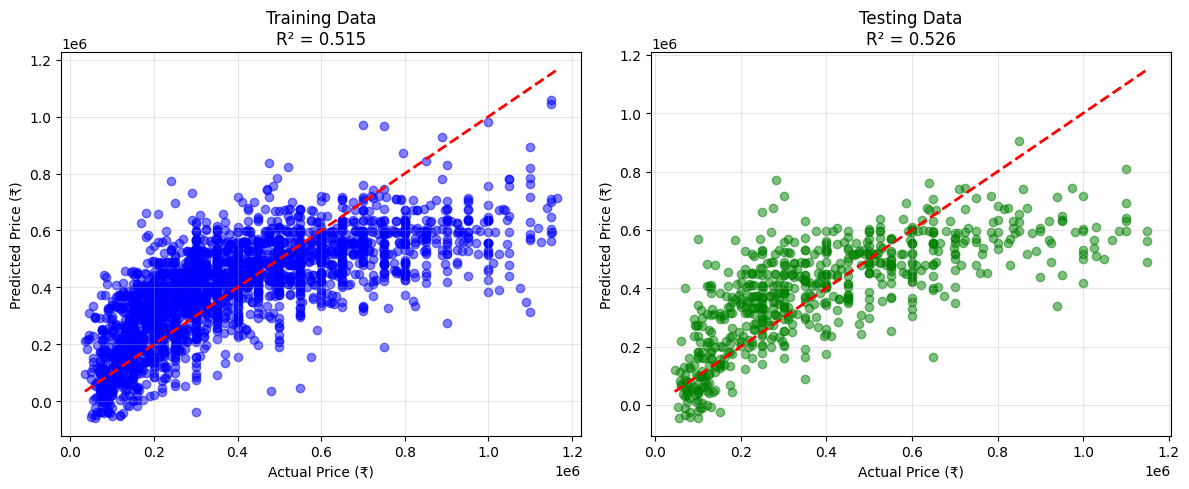

The red line shows perfect predictions.
Points closer to the red line = better predictions.


In [11]:
# Step 11: Visualize the results
print("Creating visualizations...")

# Plot 1: Actual vs Predicted prices
plt.figure(figsize=(12, 5))

# Training data plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Price (₹)')
plt.ylabel('Predicted Price (₹)')
plt.title(f'Training Data\nR² = {train_r2:.3f}')
plt.grid(True, alpha=0.3)

# Testing data plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (₹)')
plt.ylabel('Predicted Price (₹)')
plt.title(f'Testing Data\nR² = {test_r2:.3f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The red line shows perfect predictions.")
print("Points closer to the red line = better predictions.")

In [12]:
# Step 12: Show some example predictions
print("Example Predictions:")
print("=" * 50)

# Show 10 random examples
sample_indices = np.random.choice(len(X_test), 10, replace=False)

for i, idx in enumerate(sample_indices):
    actual = y_test.iloc[idx]
    predicted = y_test_pred[idx]
    error = abs(actual - predicted)
    error_pct = (error / actual) * 100
    
    print(f"Car {i+1}:")
    print(f"  Actual Price:    ₹{actual:,.0f}")
    print(f"  Predicted Price: ₹{predicted:,.0f}")
    print(f"  Error:           ₹{error:,.0f} ({error_pct:.1f}%)")
    print()

Example Predictions:
Car 1:
  Actual Price:    ₹1,000,000
  Predicted Price: ₹518,071
  Error:           ₹481,929 (48.2%)

Car 2:
  Actual Price:    ₹350,000
  Predicted Price: ₹299,606
  Error:           ₹50,394 (14.4%)

Car 3:
  Actual Price:    ₹400,000
  Predicted Price: ₹561,910
  Error:           ₹161,910 (40.5%)

Car 4:
  Actual Price:    ₹509,999
  Predicted Price: ₹517,461
  Error:           ₹7,462 (1.5%)

Car 5:
  Actual Price:    ₹950,000
  Predicted Price: ₹630,726
  Error:           ₹319,274 (33.6%)

Car 6:
  Actual Price:    ₹229,999
  Predicted Price: ₹508,937
  Error:           ₹278,938 (121.3%)

Car 7:
  Actual Price:    ₹725,000
  Predicted Price: ₹593,436
  Error:           ₹131,564 (18.1%)

Car 8:
  Actual Price:    ₹110,000
  Predicted Price: ₹270,149
  Error:           ₹160,149 (145.6%)

Car 9:
  Actual Price:    ₹275,000
  Predicted Price: ₹407,905
  Error:           ₹132,905 (48.3%)

Car 10:
  Actual Price:    ₹600,000
  Predicted Price: ₹439,714
  Error:       

In [13]:
# Step 13: Understand what affects car prices
print("What affects car prices the most?")
print("=" * 40)

# Get feature importance (coefficients)
feature_importance = []
for i, feature in enumerate(features):
    coef = model.coef_[i]
    feature_importance.append((feature, coef, abs(coef)))

# Sort by importance (absolute value)
feature_importance.sort(key=lambda x: x[2], reverse=True)

print("Most important features:")
for i, (feature, coef, abs_coef) in enumerate(feature_importance):
    if coef > 0:
        effect = "increases"
    else:
        effect = "decreases"
    
    print(f"{i+1}. {feature}: {effect} price by ₹{abs(coef):.0f} per unit")

print(f"\nBase price (when all features are 0): ₹{model.intercept_:,.0f}")

What affects car prices the most?
Most important features:
1. age: decreases price by ₹2136458675333620992 per unit
2. year: decreases price by ₹2136458675333474816 per unit
3. fuel_num: increases price by ₹59480 per unit
4. is_premium: increases price by ₹37706 per unit
5. is_luxury: increases price by ₹37304 per unit
6. transmission_num: increases price by ₹25736 per unit
7. km_driven: increases price by ₹18432 per unit
8. owner_num: decreases price by ₹15360 per unit
9. seller_num: increases price by ₹13904 per unit
10. km_per_year: decreases price by ₹13296 per unit

Base price (when all features are 0): ₹393,408


In [14]:
# Step 14: Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)

print(f"📊 Dataset: {len(data_clean)} used cars")
print(f"🎯 Model Accuracy: {test_r2*100:.1f}%")
print(f"💰 Average Prediction Error: ₹{test_mae:,.0f}")
print(f"🔧 Features Used: {len(features)}")

print(f"\n📈 Key Insights:")
print(f"• The model can predict car prices with {test_r2*100:.1f}% accuracy")
print(f"• Most important factor: {feature_importance[0][0]}")
print(f"• Typical prediction error: ₹{test_mae:,.0f}")

if test_r2 > 0.7:
    print(f"\n✅ This model is good enough for practical use!")
else:
    print(f"\n⚠️ This model could be improved with more data or features.")



SUMMARY
📊 Dataset: 3254 used cars
🎯 Model Accuracy: 52.6%
💰 Average Prediction Error: ₹130,041
🔧 Features Used: 10

📈 Key Insights:
• The model can predict car prices with 52.6% accuracy
• Most important factor: age
• Typical prediction error: ₹130,041

⚠️ This model could be improved with more data or features.
